#### Data processing

In [2]:
import pandas as pd

input = pd.read_csv('Brain_eid_FA.csv')
covariate = pd.read_csv('age_sex_head_brain.csv')
count = pd.read_csv('score_counts_brain.csv')

data = pd.merge(input, covariate, on='eid')
data = pd.merge(data, count, on='eid')

data3 = data[data['D_count'] == 0]
data = data[data['D_count'] != 0]
data1 = data[(data['D_count'] >= 2)]
data2 = data[(data['D_count'] <  2)]

print("all:", data.shape[0])
print("Health:", data3.shape[0])
print("Co:", data1.shape[0])
print("Single:", data2.shape[0])

data1.to_csv('FA_Co.csv',index=False)
data2.to_csv('FA_Single.csv',index=False)
data3.to_csv('FA_HC.csv',index=False)

all: 11042
Health: 24014
Co: 4038
Single: 7004


In [ ]:
import pandas as pd
from scipy.stats import f_oneway

data_1 = pd.read_csv('Co.csv')
data_2 = pd.read_csv('Single.csv')
data_3 = pd.read_csv('HC.csv')

d1 = data_1['D']
d2 = data_2['D']
d3 = data_3['D']

f_statistic, p_value = f_oneway(d1, d2, d3)
print("F-statistic:", f_statistic)
print("P-value:", '%f' % p_value)

#### Oneway ANOVA (analysis of variance)

In [12]:
import pandas as pd
from scipy.stats import f_oneway

data_1 = pd.read_csv('FA_Co.csv')
data_2 = pd.read_csv('FA_Single.csv')
data_3 = pd.read_csv('FA_HC.csv')

data1 = data_1.iloc[:, 1:-9]
data2 = data_2.iloc[:, 1:-9]
data3 = data_3.iloc[:, 1:-9]

labels = pd.read_csv('D:/python_code/cluster/Updated_FA.csv')

new_columns = labels['Description'].tolist()

data1.columns = new_columns
data2.columns = new_columns
data3.columns = new_columns

"""data1 = data1.iloc[:, 111:]
data2 = data2.iloc[:, 111:]
data3 = data3.iloc[:, 111:]"""

labels = data1.columns

alpha = 0.05
significant_columns = []
f_statistic_list = []
f_scores_df = pd.DataFrame(columns=['col_name', 'f_statistic', 'p_value'])

for col_name in labels:
    f_statistic, p_value = f_oneway(data1[col_name], data2[col_name], data3[col_name])
    f_statistic_list.append((f_statistic, col_name))

    f_scores_df.loc[len(f_scores_df)] = [col_name, f_statistic, p_value]

    alpha_adjusted = alpha / len(new_columns)

    if p_value < alpha_adjusted:
        #print("At a significance level of", alpha_adjusted, "There are significant differences in the means of at least one set of data. \n")
        significant_columns.append(col_name)
    else: 
        print("Column:", col_name)
        print("At a significance level of", alpha_adjusted, "There was no significant difference in the mean values of the data in each group. \n")

sorted_f_statistic_list = sorted(f_statistic_list, key=lambda x: x[0], reverse=True)
sorted_column_names = [col_name for f_statistic, col_name in sorted_f_statistic_list]

#f_scores_df.to_csv('FA f score.csv', index=False)
print(len(significant_columns))

Column: pontine crossing tract
At a significance level of 0.0010416666666666667 There was no significant difference in the mean values of the data in each group. 

47


#### Two-sample t-test with covariates

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import f
from statsmodels.stats.multitest import multipletests

def y_regress_ss(Y, X):
    coefficients = np.linalg.lstsq(X, Y, rcond=None)[0]

    predicted = np.dot(X, coefficients)

    residuals = Y - predicted

    SSE = np.sum(residuals**2)

    return coefficients, residuals, SSE

def y_TTest2Cov(Variable1, Variable2, CovariateVariable1=None, CovariateVariable2=None):
    if CovariateVariable1 is None:
        CovariateVariable1 = np.array([])
    if CovariateVariable2 is None:
        CovariateVariable2 = np.array([])

    DependentVariable = np.concatenate((Variable1, Variable2))
    CovariateVariable = np.vstack((CovariateVariable1, CovariateVariable2))
    GroupLabel = np.concatenate((np.ones(len(Variable1)), -1 * np.ones(len(Variable2))))
    Df_E = DependentVariable.shape[0] - 2 - CovariateVariable.shape[1]

    b, r, SSE_H = y_regress_ss(DependentVariable, np.column_stack((np.ones(len(DependentVariable)), CovariateVariable)))

    b, r, SSE = y_regress_ss(DependentVariable, np.column_stack((np.ones(len(DependentVariable)), GroupLabel, CovariateVariable)))

    F = ((SSE_H - SSE) / 1) / (SSE / Df_E)
    P = 1 - f.cdf(F, 1, Df_E)
    T = np.sqrt(F) * np.sign(b[1])

    return T, P

In [14]:
def perform_t_test(data1, data2, covariate1, covariate2, i):
    significant_columns = []
    result_df = pd.DataFrame(columns=['i', 'col_name', 'TTest2Cov_T', 'TTest2Cov_P'])

    for col_name in data1.columns:
        col_data1 = np.array(data1[col_name])
        col_data2 = np.array(data2[col_name])
        covariate1_array = np.array(covariate1)
        covariate2_array = np.array(covariate2)
        
        TTest2Cov_T, TTest2Cov_P = y_TTest2Cov(col_data1, col_data2, covariate1_array, covariate2_array)

        alpha = 0.05
        p_values = [TTest2Cov_P]

        corrected_p_values = multipletests(p_values, alpha=alpha, method='sidak')[1]

        result_df = pd.concat([result_df, pd.DataFrame({'i': [i], 'col_name': [col_name], 'TTest2Cov_T': [TTest2Cov_T], 'TTest2Cov_P': [TTest2Cov_P]})], ignore_index=True)

        if corrected_p_values[0] < alpha:
            print(f"{i} in {col_name} are significant differences")
            print(f"{i} in {col_name} T values is:{TTest2Cov_T}")
            print(f"{i} in {col_name} p values is:{TTest2Cov_P}")
            #result_df = pd.concat([result_df, pd.DataFrame({'i': [i], 'col_name': [col_name], 'TTest2Cov_T': [TTest2Cov_T], 'TTest2Cov_P': [TTest2Cov_P]})], ignore_index=True)
            significant_columns.append(col_name)

    result_df.to_csv(f'{i}_result.csv', index=False)

    result_df['TTest2Cov_T'] = result_df['TTest2Cov_T'].abs()
    
    result_df = result_df.sort_values(by='TTest2Cov_T', ascending=False)

    top_10_col_names = result_df['col_name'].head(10).tolist()

    return significant_columns, top_10_col_names

#### D factor T test

In [15]:
data_1 = pd.read_csv('FA_Co.csv')
data_2 = pd.read_csv('FA_Single.csv')
data_3 = pd.read_csv('FA_HC.csv')

data1 = data_1.iloc[:, 1:-9]
data2 = data_2.iloc[:, 1:-9]
data3 = data_3.iloc[:, 1:-9]

labels = pd.read_csv('D:/python_code/cluster/Updated_FA.csv')

new_columns = labels['Description'].tolist()

data1.columns = new_columns
data2.columns = new_columns
data3.columns = new_columns

covariate1 = data_1[['age','sex']]
covariate2 = data_2[['age','sex']]
covariate3 = data_3[['age','sex']]

significant_columns_1_2, top_10_1_2 = perform_t_test(data1, data2, covariate1, covariate2, 'Co_Single')
significant_columns_1_3, top_10_1_3 = perform_t_test(data1, data3, covariate1, covariate3, 'Co_HC')
significant_columns_2_3, top_10_2_3 = perform_t_test(data2, data3, covariate2, covariate3, 'Single_HC')

Co_Single in middle cerebellar peduncle are significant differences
Co_Single in middle cerebellar peduncle T values is:-2.337018249982292
Co_Single in middle cerebellar peduncle p values is:0.019456021056128203
Co_Single in pontine crossing tract are significant differences
Co_Single in pontine crossing tract T values is:2.6065731031141004
Co_Single in pontine crossing tract p values is:0.009157621566649565
Co_Single in genu of corpus callosum are significant differences
Co_Single in genu of corpus callosum T values is:-6.83111228324852
Co_Single in genu of corpus callosum p values is:8.869127654520526e-12
Co_Single in body of corpus callosum are significant differences
Co_Single in body of corpus callosum T values is:-6.32843086062807
Co_Single in body of corpus callosum p values is:2.5726742958198656e-10
Co_Single in splenium of corpus callosum are significant differences
Co_Single in splenium of corpus callosum T values is:-4.282474063266189
Co_Single in splenium of corpus callosum

In [16]:
set1 = set(significant_columns_1_2)
set2 = set(significant_columns_1_3)
set3 = set(significant_columns_2_3)

intersection = set1.intersection(set2,set3)
significant2_2 = list(intersection)
len(significant2_2)

44

#### Significantly strongest region of the three groups

In [11]:
set1 = set(top_10_1_2)

intersection = set1

result_list = list(intersection)

print(len(result_list))

significant_data1 = data1[result_list]
significant_data2 = data2[result_list]

combined_data = pd.concat([significant_data1.assign(Group='Group 1'),
                           significant_data2.assign(Group='Group 2')])

new_df = pd.DataFrame(columns=['value', 'name', 'Group'])

df = combined_data

for col in df.columns[:-1]:
    name = col
    data = pd.DataFrame({'value': df[col], 'name': name, 'Group': df['Group']})
    new_df = pd.concat([new_df, data], ignore_index=True)

10


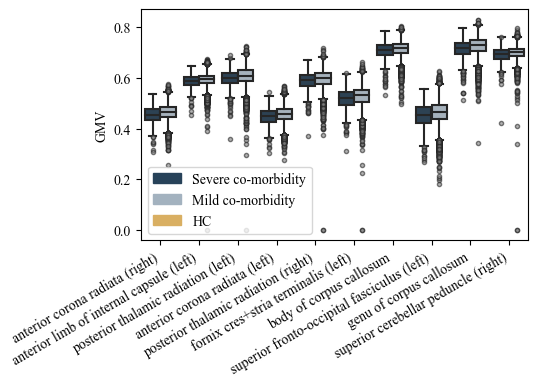

In [12]:
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'

legend_labels = [mpatches.Patch(color='#274259', label='Severe co-morbidity'),
                 mpatches.Patch(color='#A3B2BF', label='Mild co-morbidity'),
                 mpatches.Patch(color='#D9AF62', label='HC')]

flierprops = dict(marker='o', markersize=3, markerfacecolor='grey', linestyle='none', alpha=0.6)

plt.figure(figsize=(5, 3))
sns.boxplot(x='name', y='value', data=new_df, hue='Group', 
            palette={'Group 1':'#274259', 'Group 2':'#A3B2BF','Group 3':'#D9AF62'}, width=0.8,
            flierprops=flierprops)
plt.xticks(rotation=30, ha='right')
plt.xlabel("")
plt.ylabel("GMV", fontsize=10)

plt.legend(handles=legend_labels)
#plt.savefig("D:/python_code/cluster/picture/GMV 3 Cluster.jpeg", dpi=500, bbox_inches='tight')
plt.show()

#### Two or two significant regions in three groups

In [19]:
set1 = set(significant_columns_1_2)
set2 = set(significant_columns_1_3)
set3 = set(significant_columns_2_3)

intersection = set1.intersection(set2,set3)

ten_list = sorted_column_names[:10]
set_F = set(ten_list)
intersection = intersection.intersection(set_F)
result_list = list(intersection)
result_list = sorted(result_list)
print(result_list)

new_columns = ['ACR (L)', 'ACR (R)', 'Fornix', 'FCST (L)', 'FCST (R)',
               'GCC', 'PTR (L)', 'PTR (R)', 'SFOF (L)', 'SFOF (R)']

significant_data1 = data1[result_list]
significant_data2 = data2[result_list]
significant_data3 = data3[result_list]

significant_data1.columns = new_columns
significant_data2.columns = new_columns
significant_data3.columns = new_columns

combined_data = pd.concat([significant_data1.assign(Group='Group 1'),
                           significant_data2.assign(Group='Group 2'),
                           significant_data3.assign(Group='Group 3')])

new_df = pd.DataFrame(columns=['value', 'name', 'Group'])

df = combined_data

for col in df.columns[:-1]:
    name = col
    data = pd.DataFrame({'value': df[col], 'name': name, 'Group': df['Group']})
    new_df = pd.concat([new_df, data], ignore_index=True)

['anterior corona radiata (left)', 'anterior corona radiata (right)', 'fornix', 'fornix cres+stria terminalis (left)', 'fornix cres+stria terminalis (right)', 'genu of corpus callosum', 'posterior thalamic radiation (left)', 'posterior thalamic radiation (right)', 'superior fronto-occipital fasciculus (left)', 'superior fronto-occipital fasciculus (right)']


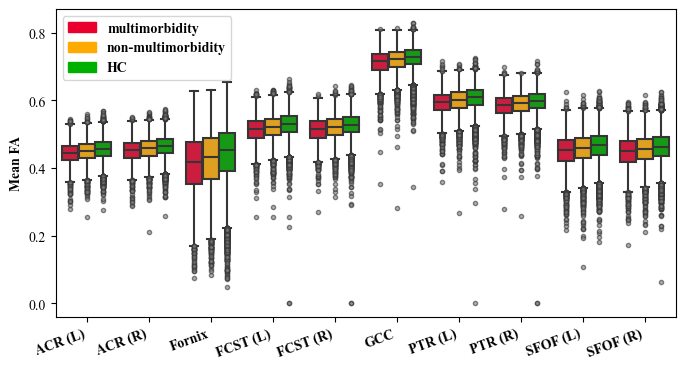

In [20]:
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties

mpl.rcParams['font.family'] = 'Times New Roman'

legend_labels = [mpatches.Patch(color='#E9002D', label='multimorbidity'),
                 mpatches.Patch(color='#FFAA00', label='non-multimorbidity'),
                 mpatches.Patch(color='#00B000', label='HC')]

flierprops = dict(marker='o', markersize=3, markerfacecolor='grey', linestyle='none', alpha=0.6)

plt.figure(figsize=(8, 4))
sns.boxplot(x='name', y='value', data=new_df, hue='Group', 
            palette={'Group 1': '#E9002D', 'Group 2': '#FFAA00','Group 3': '#00B000'}, width=0.8,
            flierprops=flierprops)
plt.xticks(rotation=20, ha='right',fontsize=10, fontweight='bold')
plt.xlabel("")
plt.ylabel("Mean FA", fontsize=10, fontweight='bold')

font = FontProperties()
font.set_weight('bold')

plt.legend(handles=legend_labels, prop=font)
plt.savefig("FA 3 Cluster.jpeg", dpi=1000, bbox_inches='tight')
plt.show()